# Growth mixture model experiment

Data from Hox et al. (2017), showcased in a [JASP tutorial](https://jasp-stats.org/2022/02/22/latent-growth-curve-modeling-lgcm-in-jasp/).

Set up CUDA

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = 3
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [3]


Set up imports

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import distrax as dx
import pandas as pd
import pickle
from pathlib import Path

from jax.nn import softmax
from jax.scipy.special import logsumexp

from typing import Callable
from jaxtyping import Float

import sys
sys.path.append(os.path.expanduser('~/Documents/Repos/bayesianmodels'))
from uicsmodels.bayesianmodels import BayesianModel, GibbsState

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from blackjax import rmh, nuts, window_adaptation
from jax.scipy.stats import gaussian_kde

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

key = jrnd.PRNGKey(1234)

The growth mixture model as defined in the paper in Section 4.2.2. Since the model is not hierarchical, the `BayesianModel` class automatically constructs the correct `logprior_fn`, so we do not have to do this manually. We basically only define the `loglikelihood_fn`. Some rewriting of log-probabilities results in more efficient and numerically stable computations.

In [ ]:
def centered_softmax(v):
    return softmax(jnp.insert(v, 0, 0, axis=0))

#
class GrowthMixtureModel(BayesianModel):
    r"""The growth mixture model

   
    """

    def __init__(self, Y, degree, priors: dict, X=None, K=3):
        self.Y = Y   
        N, T = self.Y.shape
        self.N = N
        self.T = T
        if X is None:
            X = jnp.linspace(0, 1, num=T)
        
        get_polynomial = lambda x, d: x**d
        self.X = jax.vmap(get_polynomial, in_axes=(None, 0))(X, jnp.arange(degree + 1))
        self.degree = degree  # curve polynomial degree
        self.K = K
        self.param_priors = priors

    #
    def loglikelihood_fn(self) -> Callable:
        """

        It is easier to do the centered softmax trick in the likelihood than via
        distrax, because we can't propose samples with the right constraints.
        """

        def loglikelihood_fn_(state: GibbsState, Y = None) -> Float:
            if Y is None:
                Y = self.Y
            position = getattr(state, 'position', state)
            w = centered_softmax(position['beta'])
            eta = position['eta']
            mu = jnp.dot(eta, self.X)
            sigma = position['sigma']
            _, T = self.Y.shape

            def a_k(w_k, mu_k, sigma_k, y_i):
                return jnp.log(w_k) - T/2*jnp.log(2*jnp.pi*sigma_k**2) - 1 / (2*sigma_k**2) * jnp.sum((y_i - mu_k)**2)
            
            #
            def log_lik_y_i(y_i):
                return logsumexp(jax.vmap(a_k, in_axes=(0, 0, 0, None))(w, mu, sigma, y_i))
            
            #
            loglik_k = jnp.sum(jax.vmap(log_lik_y_i, in_axes=0)(Y))
            return loglik_k
        #
        return loglikelihood_fn_

    #
#

Helper functions

In [3]:
def plot_posterior(smpls, K, degree):
    nbins=40

    _, axes = plt.subplots(nrows=K, ncols=degree+1, constrained_layout=True, figsize=(8, K*2), sharex='col', sharey='col')
    for k in range(K):
        for j in range(degree+1):        
            axes[k, j].hist(smpls['eta'][:, k, j].flatten(), bins=nbins, density=True)
            axes[k, j].set_xlabel(r'$\eta_{{{:s}}}$'.format(f'{k},{j}'))
        axes[k,0].set_ylabel(f'Component {k+1}')
    plt.suptitle('Coefficients for different polynomial orders')
    plt.show()

    _, axes = plt.subplots(nrows=1, ncols=K, constrained_layout=True, figsize=(8, 2), sharex=True, sharey=True)
    for k, ax in enumerate(axes):
        ax.hist(smpls['sigma'][:, k], bins=nbins, density=True)
        ax.set_xlabel(fr'$\sigma_{k+1}$')
    plt.suptitle('Observation noise per component')
    plt.show()

    beta = smpls['beta']
    w = jnp.squeeze(jax.vmap(centered_softmax, in_axes=0)(beta))

    _, axes = plt.subplots(nrows=1, ncols=K, constrained_layout=True, figsize=(8, 2), sharex=True, sharey=True)
    for k, ax in enumerate(axes):
        ax.hist(w[:, k], bins=nbins, density=True)
        ax.set_xlabel(fr'$w_{k+1}$')
    plt.suptitle('Component weight')
    plt.show()

#
def plot_fit(key, Y, smpls, K, degree, color=None, ax=None, title=None):
    N, T = Y.shape
    get_polynomial = lambda x, d: x**d
    x = jax.vmap(get_polynomial, in_axes=(None, 0))(jnp.linspace(0, 1, num=T), jnp.arange(degree + 1))
    
    num_smpls = smpls['beta'].shape[0]
    new_figure = False
    if ax is None:
        new_figure = True
        plt.figure(figsize=(12, 6))
        ax = plt.gca()
    if title is not None:
        ax.set_title(title, fontsize=MEDIUM_SIZE)

    if color is None:
        color = 'tab:orange'

    for i in range(0, num_smpls, 5):
        for k in range(K):
            eta = smpls['eta'][i, k, :]
            mu = jnp.dot(eta, x)
            ax.plot(x[1, :], mu, color=color, alpha=0.01)

    for i in range(T):
        key, subkey = jrnd.split(key)
        jitter = 0.005*jrnd.normal(subkey, shape=(N, ))
        ax.plot(jitter+x[1, i], Y[:, i], '.', color='k', alpha=0.5)
   
    if new_figure:        
        ax.set_ylabel('GPA', fontsize=MEDIUM_SIZE)
    ax.set_xlabel('Semester', fontsize=MEDIUM_SIZE)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([1.0, 4.5])
    ax.set_xticks(jnp.linspace(0, 1, T), jnp.arange(T) + 1, fontsize=SMALL_SIZE)
    ax.tick_params(axis='y', labelsize=SMALL_SIZE)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    if new_figure:
        plt.show()
    return ax

#
def data_fit(model, samples):
    loglikelihood_fn = model.loglikelihood_fn()
    LL = jnp.mean(jax.vmap(loglikelihood_fn)(samples))
    return LL

#
def KL_MC(p, q, supp, epsilon=1e-8):
    px = p(supp) + epsilon
    qx = q(supp) + epsilon  
    return 1 / len(px) * jnp.sum(px*(jnp.log(px) - jnp.log(qx)))

#

Load data from JASP website (https://jasp-stats.org/wp-content/uploads/2022/02/gpa.csv).

In [4]:
url = 'https://jasp-stats.org/wp-content/uploads/2022/02/gpa.csv'
df = pd.read_csv(url)

Y = df[['gpa1', 'gpa2', 'gpa3', 'gpa4', 'gpa5', 'gpa6']].to_numpy()
N, T = Y.shape

## Define model

1. Define the priors for the top-level parameters (see Appendix B.1 in the accompanying paper).
2. Instantiate the growth mixture model.

In [5]:
degree = 1
K = 4
num_params = K*(degree+3) - 1 

priors = dict(eta=dx.Normal(loc=jnp.zeros((K, degree + 1)), scale=2*jnp.ones((K, degree + 1))),  # polynomial regression coefficients
              sigma=dx.Transformed(dx.Normal(loc=jnp.zeros((K, )),                               # obs noise
                                             scale=jnp.ones((K, ))),
                                   tfb.Exp()),
              beta=dx.Normal(loc=jnp.zeros((K-1, )),                                             # probit of mixture weights
                             scale=jnp.ones((K-1, ))))

GrMM = GrowthMixtureModel(Y, degree=degree, priors=priors, K=K)

The first step, as an illustration, confirms the problem of multimodality when using MCMC (Metropolis or NUTS) vs SMC:

In [6]:
mh_stepsize = 0.01
rmh_parameters = dict(sigma=mh_stepsize*jnp.eye(num_params))
 
key, key_init, key_inference = jrnd.split(key, 3)
initial_state = GrMM.init_fn(key_init, num_particles=1)

mcmc_parameters = dict(kernel=rmh,
                       kernel_parameters=rmh_parameters,
                       num_samples=2_000_000,
                       num_burn=2_000_000,
                       num_thin=1_000)

mh_samples = GrMM.inference(key_inference, mode='mcmc', sampling_parameters=mcmc_parameters)

CPU times: user 5min 57s, sys: 2.1 s, total: 5min 59s
Wall time: 5min 57s


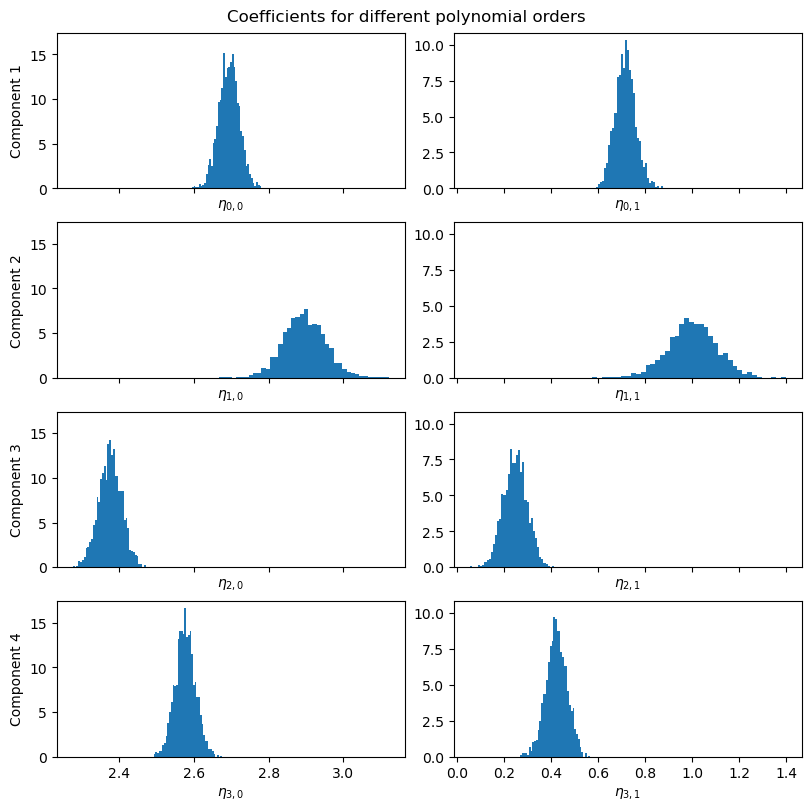

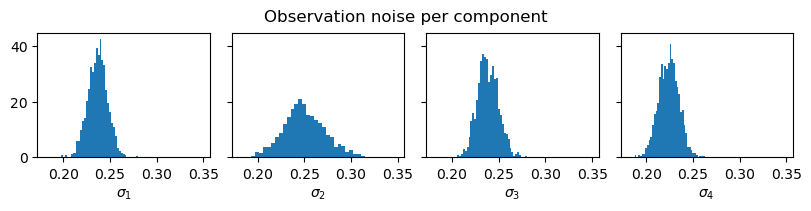

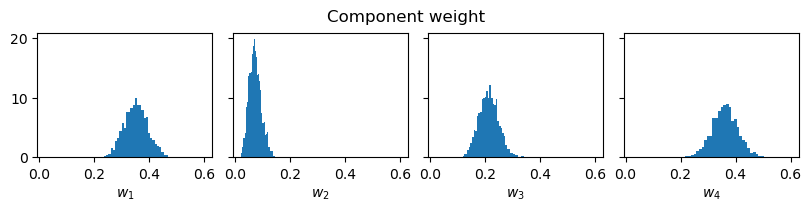

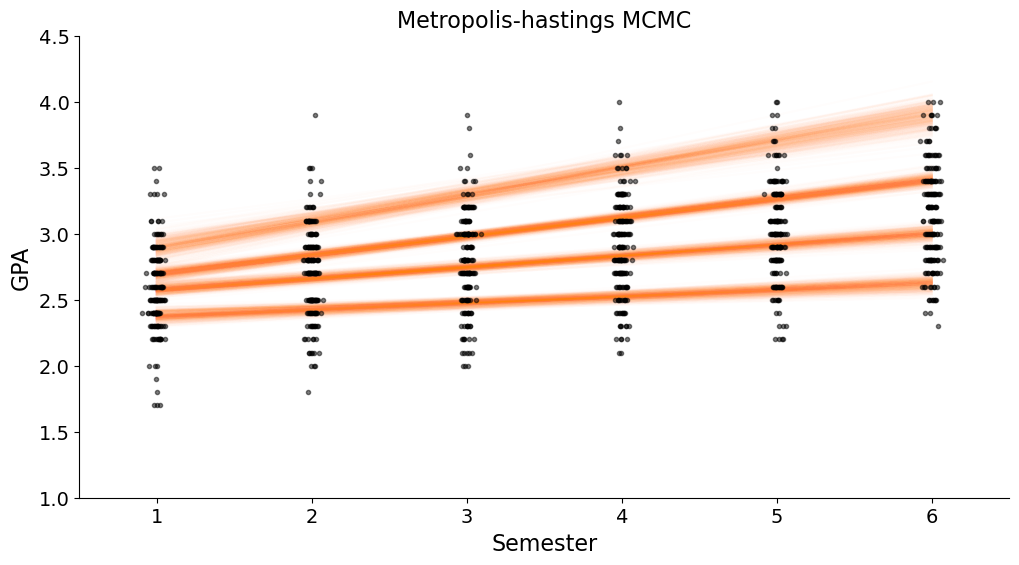

In [7]:
plot_posterior(mh_samples.position, K=K, degree=degree)

key, subkey = jrnd.split(key)
plot_fit(subkey, Y, mh_samples.position, K, degree, title='Metropolis-hastings MCMC');

Set up adaptive NUTS

In [8]:
num_samples = 2000
num_burn = 1000
num_warmup = 1000

key, key_init, key_warmup, key_inference = jrnd.split(key, 4)
logdensity = lambda state: GrMM.loglikelihood_fn()(state) + GrMM.logprior_fn()(state)
warmup = window_adaptation(nuts, logdensity)
initial_state = GrMM.init_fn(key_init, num_particles=1).position

(warm_state, warm_parameters), _ = warmup.run(key_warmup, 
                                              initial_state,
                                              num_steps=num_warmup)

nuts_parameters = dict(kernel=nuts,
                       kernel_parameters=warm_parameters,
                       initial_state=warm_state, 
                       num_samples=num_samples,
                       num_burn=num_burn)

nuts_samples = GrMM.inference(key_inference, mode='mcmc', sampling_parameters=nuts_parameters)

CPU times: user 55.2 s, sys: 3.56 s, total: 58.7 s
Wall time: 43.5 s


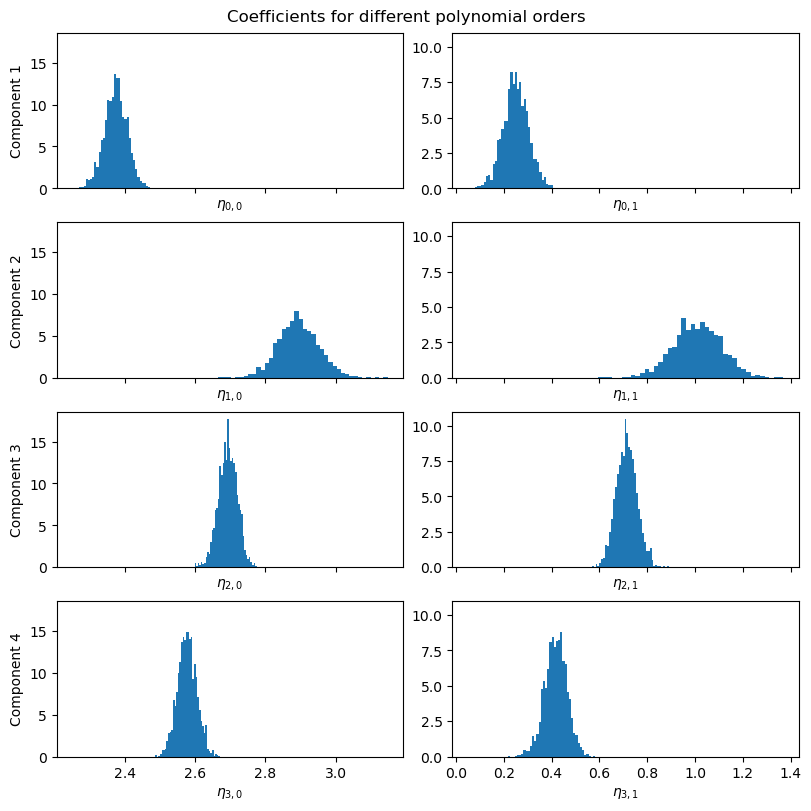

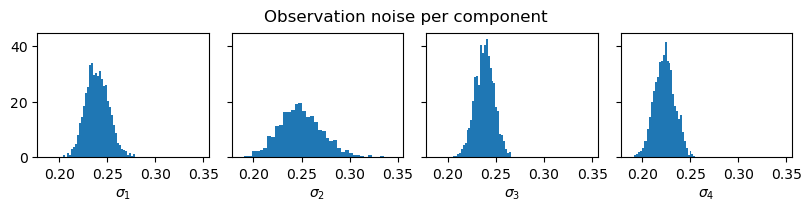

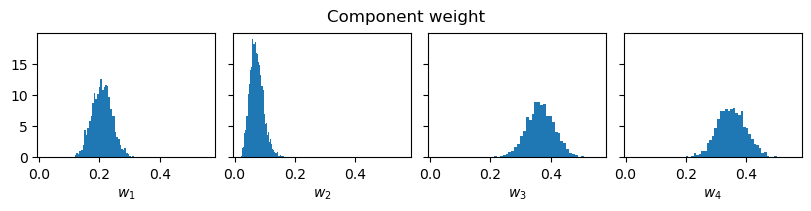

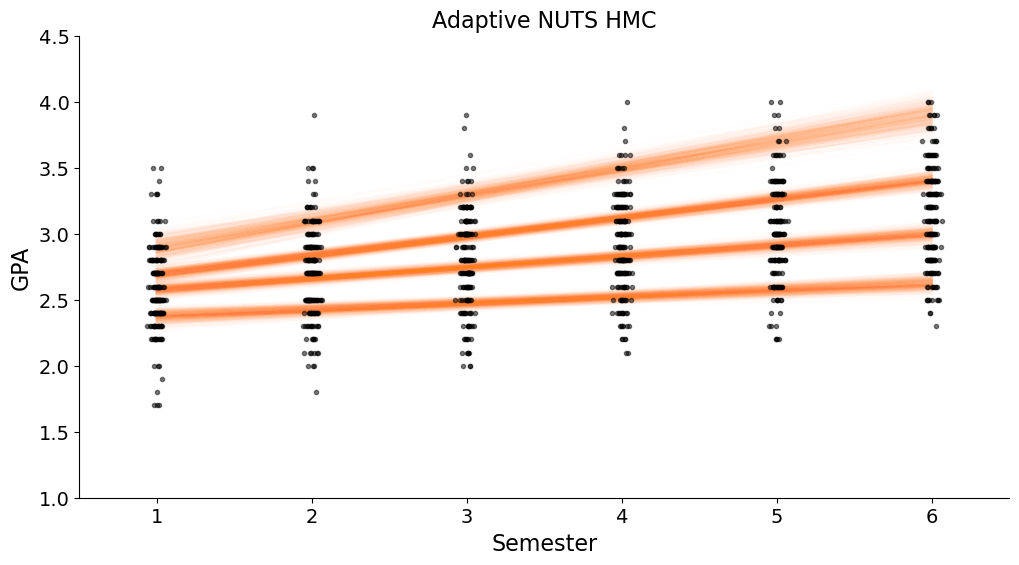

<AxesSubplot:title={'center':'Adaptive NUTS HMC'}, xlabel='Semester', ylabel='GPA'>

In [9]:
plot_posterior(nuts_samples.position, K=K, degree=degree)

key, subkey = jrnd.split(key)
plot_fit(subkey, Y, nuts_samples.position, K, degree, title='Adaptive NUTS HMC')

Set up SMC

In [10]:
key, subkey = jrnd.split(key)

num_particles = 2000
num_mcmc_steps = 1000

mh_stepsize = 0.01
rmh_parameters = dict(sigma=mh_stepsize*jnp.eye(num_params))

smc_parameters = dict(kernel=rmh,
                      kernel_parameters=rmh_parameters,
                      num_particles=num_particles,
                      num_mcmc_steps=num_mcmc_steps)

particles, num_adapt, lml = GrMM.inference(subkey, mode='mcmc-in-smc', sampling_parameters=smc_parameters)
print(f'Inference complete, {num_adapt} adaptive SMC cycles, LML: {lml}.')

Inference complete, 38 adaptive SMC cycles, LML: -203.86093139648438.
CPU times: user 16.4 s, sys: 1.52 s, total: 17.9 s
Wall time: 9.98 s


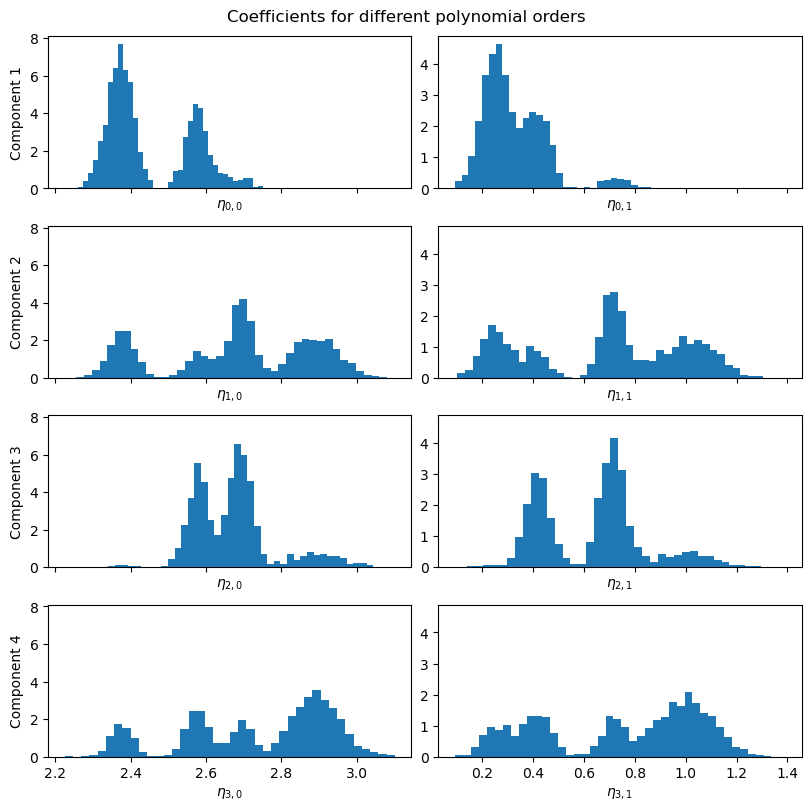

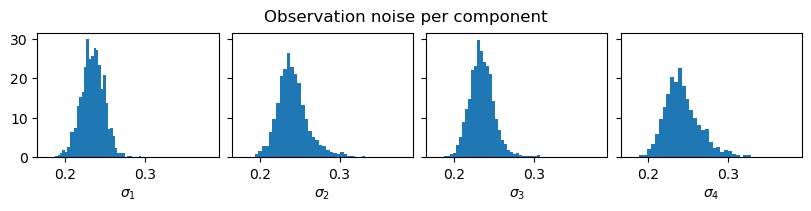

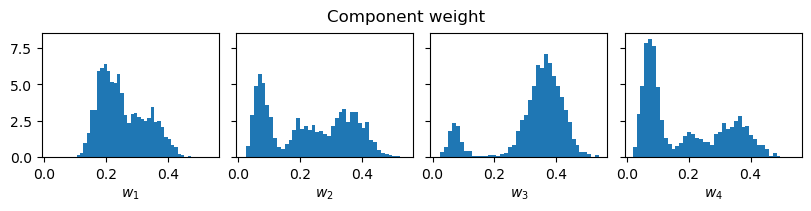

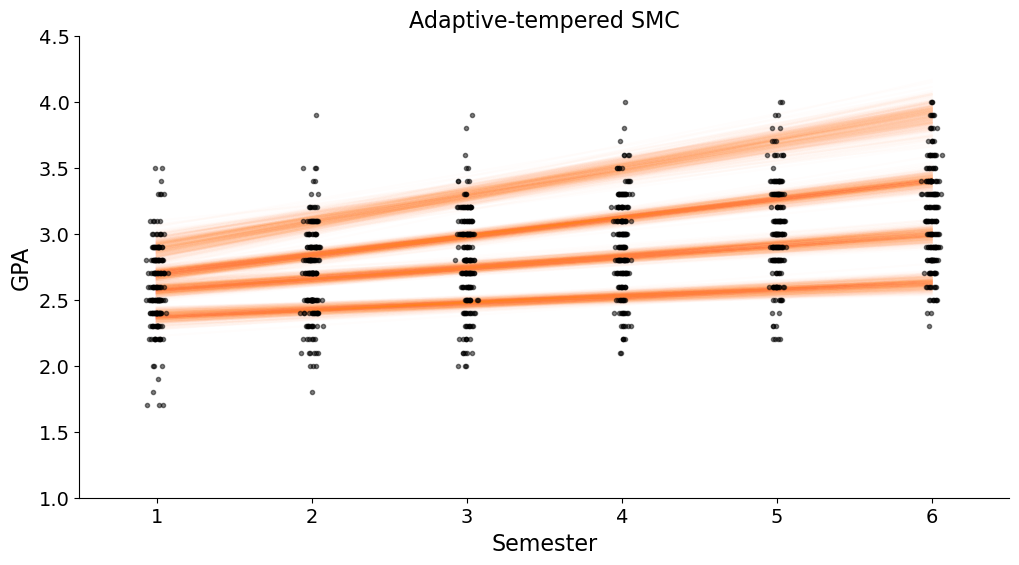

<AxesSubplot:title={'center':'Adaptive-tempered SMC'}, xlabel='Semester', ylabel='GPA'>

In [11]:
plot_posterior(particles.particles, K=K, degree=degree)
key, subkey = jrnd.split(key)
plot_fit(subkey, Y, particles.particles, K, degree, title='Adaptive-tempered SMC')

Verify that each approach results in an adequate fit to the data using the log pointwise predictive density (eq. (17) in paper):

In [12]:
print(data_fit(GrMM, mh_samples.position))
print(data_fit(GrMM, nuts_samples.position))
print(data_fit(GrMM, particles.particles))

-156.059
-156.14133
-157.65134


We see that all approaches result in a similar fit on the data. However, only SMC seems to reveal that there are multiple modes in the posterior; MH-MCMC and NUTS both show only one mode, confirming our hunch.

In [13]:
samples_per_method = [mh_samples.position, nuts_samples.position, particles.particles]
methods = ['MH', 'NUTS', 'SMC']

m = 1000

variable_settings = dict(eta0 = dict(name='eta',
                                    dim=0,
                                    support=jnp.linspace(2.2, 3.2, num=m)),
                        eta1 = dict(name='eta',
                                    dim=1,
                                    support=jnp.linspace(0.0, 1.4, num=m)))

support_eta0 = jnp.linspace(2.2, 3.2, num=1000)
support_eta1 = jnp.linspace(0.0, 1.4, num=1000)

for varsettings in variable_settings.values():
    varname = varsettings['name']
    vardim = varsettings['dim']
    varsupport = varsettings['support']
    print(f'{varname}_{vardim}')
    for samples, method in zip(samples_per_method, methods):        
        kl_scores = []
        for k1 in range(K):        
            p = gaussian_kde(samples[varname][:, k1, vardim].flatten())
            for k2 in range(k1+1, K):
                q = gaussian_kde(samples[varname][:, k2, vardim].flatten())
                kl_score = KL_MC(p, q, varsupport)
                kl_scores.append(kl_score)
        print(f'{method}:\t{jnp.mean(jnp.asarray(kl_scores))}')



eta_0
MH:	16.36301612854004
NUTS:	18.76063346862793
SMC:	1.040163278579712
eta_1
MH:	10.992462158203125
NUTS:	11.94509506225586
SMC:	0.5806756019592285


## Systematic evaluation of multimodal coverage by Metropolis-MCMC, NUTS-HMC and SMC

Within ten-fold cross-validation, repeat the procedure above; quantify the similarity between different distributions and determine the predictive performance and running time.

In [14]:
def run_nuts(key, model, num_samples=2000, num_burn=1000, num_warmup=1000):   
    """Run NUTS HMC with window adaptation
    """
    key, key_init, key_warmup, key_inference = jrnd.split(key, 4)
    logdensity = lambda state: model.loglikelihood_fn()(state) + model.logprior_fn()(state)
    warmup = window_adaptation(nuts, logdensity)
    initial_state = model.init_fn(key_init, num_particles=1).position

    (warm_state, warm_parameters), _ = warmup.run(key_warmup, 
                                                initial_state,
                                                num_steps=num_warmup)

    nuts_parameters = dict(kernel=nuts,
                        kernel_parameters=warm_parameters,
                        initial_state=warm_state, 
                        num_samples=num_samples,
                        num_burn=num_burn)

    nuts_samples = model.inference(key_inference, mode='mcmc', sampling_parameters=nuts_parameters)
    return nuts_samples

#
def run_mh(key, model, num_samples=2_000_000, num_burn=2_000_000, num_thin=1_000):
    """Run Metropolis-Hastings MCMC with a proposal covariance matrix of 0.01*I_n
    """
    mh_stepsize = 0.01
    rmh_parameters = dict(sigma=mh_stepsize*jnp.eye(num_params))
    
    mcmc_parameters = dict(kernel=rmh,
                           kernel_parameters=rmh_parameters,
                           num_samples=num_samples,
                           num_burn=num_burn,
                           num_thin=num_thin)

    mh_samples = model.inference(key, mode='mcmc', sampling_parameters=mcmc_parameters)
    return mh_samples

#
def run_smc(key, model, num_particles=2000, num_mcmc=1000):
    """Run adaptive-tempered SMC with Metropolis-Hastings MCMC for the mutation steps
    """
    mh_stepsize = 0.01
    rmh_parameters = dict(sigma=mh_stepsize*jnp.eye(num_params))

    smc_parameters = dict(kernel=rmh,
                        kernel_parameters=rmh_parameters,
                        num_particles=num_particles,
                        num_mcmc_steps=num_mcmc)

    particles, num_adapt, lml = model.inference(key, mode='mcmc-in-smc', sampling_parameters=smc_parameters)
    return particles, num_adapt, lml

#
def get_kl_eta(samples, varsettings):
    varname = varsettings['name']
    vardim = varsettings['dim']
    varsupport = varsettings['support']
          
    kl_scores = []
    for k1 in range(K):        
        p = gaussian_kde(samples[varname][:, k1, vardim].flatten())
        for k2 in range(k1+1, K):
            q = gaussian_kde(samples[varname][:, k2, vardim].flatten())
            kl_score = KL_MC(p, q, varsupport)
            kl_scores.append(kl_score)
    return jnp.mean(jnp.asarray(kl_scores))

#

num_params = K*(degree+3) - 1 
variable_settings = dict(eta0 = dict(name='eta',
                                     dim=0,
                                     support=jnp.linspace(2.2, 3.2, num=m)),
                         eta1 = dict(name='eta',
                                     dim=1,
                                     support=jnp.linspace(0.0, 1.4, num=m)))

The procedure takes a while (1h20m on an NVIDIA Quadro RTX 6000), so the results are saved to a file. The cell below can be skipped and the results can be loaded directly.

In [32]:
import time
from tqdm import tqdm

def LPPD(samples, loglik_fn, x_test):
    state_in_axes = jax.tree_map(lambda l: 0, samples)
    return jnp.mean(jax.vmap(loglik_fn, in_axes=(state_in_axes, None))(samples, x_test)) / len(x_test)

#

shuffled_ix = jrnd.permutation(subkey, jnp.arange(N))

num_folds = 10
data_per_fold = int(N / num_folds)

degree = 1
K = 4
num_params = K*(degree+3) - 1 

priors = dict(eta=dx.Normal(loc=jnp.zeros((K, degree + 1)), scale=2*jnp.ones((K, degree + 1))),  # polynomial regression coefficients
            sigma=dx.Transformed(dx.Normal(loc=jnp.zeros((K, )),                               # obs noise
                                            scale=jnp.ones((K, ))),
                                tfb.Exp()),
            beta=dx.Normal(loc=jnp.zeros((K-1, )),                                             # probit of mixture weights
                            scale=jnp.ones((K-1, ))))

num_particles = 2000
num_mcmc_steps = 1000

mh_stepsize = 0.01
rmh_parameters = dict(sigma=mh_stepsize*jnp.eye(num_params))

smc_parameters = dict(kernel=rmh,
                      kernel_parameters=rmh_parameters,
                      num_particles=num_particles,
                      num_mcmc_steps=num_mcmc_steps)

lppd_scores = jnp.zeros((num_folds, 3))
kl_scores = jnp.zeros((num_folds, 3))
timings = jnp.zeros((num_folds, 3))

for fold in tqdm(range(num_folds)):
    lo = data_per_fold*fold
    hi = data_per_fold*(fold+1)
    fold_ix = shuffled_ix[lo:hi]
    Y_train = Y[~jnp.isin(jnp.arange(N), fold_ix), :]
    Y_test = Y[fold_ix, :]

    GrMM = GrowthMixtureModel(Y_train, degree=degree, priors=priors, K=K)

    key, key_mh, key_nuts, key_smc = jrnd.split(key, 4)

    start_mh = time.time()
    mh_samples = run_mh(key_mh, GrMM)
    timings = timings.at[fold, 0].set(time.time() - start_mh)
    lppd_scores = lppd_scores.at[fold, 0].set(LPPD(mh_samples.position, GrMM.loglikelihood_fn(), Y_test))
    kl_scores = kl_scores.at[fold, 0].set(get_kl_eta(mh_samples.position, variable_settings['eta0']))

    start_nuts = time.time()
    nuts_samples = run_nuts(key_nuts, GrMM)
    timings = timings.at[fold, 1].set(time.time() - start_nuts)
    lppd_scores = lppd_scores.at[fold, 1].set(LPPD(nuts_samples.position, GrMM.loglikelihood_fn(), Y_test))
    kl_scores = kl_scores.at[fold, 1].set(get_kl_eta(nuts_samples.position, variable_settings['eta0']))

    start_smc = time.time()   
    particles, *_ = run_smc(key_smc, GrMM)
    timings = timings.at[fold, 2].set(time.time() - start_smc)
    lppd_scores = lppd_scores.at[fold, 2].set(LPPD(particles.particles, GrMM.loglikelihood_fn(), Y_test))
    kl_scores = kl_scores.at[fold, 2].set(get_kl_eta(particles.particles, variable_settings['eta0']))

#

temporary_results_file = os.path.join(Path(os.getcwd()).parents[0], 'Data/xvalidation_results.pickle')
to_file = dict(lppd_scores=lppd_scores, timings=timings, kl_scores=kl_scores, mh_samples=mh_samples, nuts_samples=nuts_samples, particles=particles)
with open(temporary_results_file, 'wb') as file:
    pickle.dump(to_file, file)

100%|██████████| 10/10 [1:19:17<00:00, 475.75s/it]


In [33]:
with open(temporary_results_file, 'rb') as file:
    data = pickle.load(file)

lppd_scores = data['lppd_scores']
kl_scores = data['kl_scores']
timings = data['timings']
mh_samples = data['mh_samples']
nuts_samples = data['nuts_samples']
particles = data['particles']

Print in LaTeX format (Table 1 in paper):

In [30]:
M = lppd_scores.shape[1]

scorelabels = ['LPPD', 'KL-divergence', 'Running time']
methodlabels = ['RMH', 'NUTS', 'SMC']

for m in range(M):
    print(f'{methodlabels[m]}\t&\t ${jnp.mean(lppd_scores, axis=0)[m]:0.2f} \\pm {jnp.std(lppd_scores, axis=0)[m]:0.2f}$ \t&\t ${jnp.mean(kl_scores, axis=0)[m]:0.2f} \\pm {jnp.std(kl_scores, axis=0)[m]:0.2f}$ \t&\t ${jnp.mean(timings, axis=0)[m]:0.2f} \\pm {jnp.std(timings, axis=0)[m]:0.2f}$ \\\\')

RMH	&	 $-0.96 \pm 0.40$ 	&	 $15.63 \pm 2.58$ 	&	 $370.36 \pm 13.70$ \\
NUTS	&	 $-0.94 \pm 0.41$ 	&	 $16.66 \pm 1.05$ 	&	 $43.61 \pm 6.48$ \\
SMC	&	 $-0.94 \pm 0.41$ 	&	 $1.91 \pm 1.89$ 	&	 $9.60 \pm 0.43$ \\


Spend too much timing on picking out color schemes...

In [22]:
def darken_hex_color(hex_color, percentage):
    if not hex_color.startswith('#'):
        hex_color = '#' + hex_color

    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)

    # Darken each component
    r = int(r * (1 - percentage / 100))
    g = int(g * (1 - percentage / 100))
    b = int(b * (1 - percentage / 100))

    # Ensure values are within 0-255
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))

    # Convert RGB back to hex
    darkened_hex_color = f'#{r:02x}{g:02x}{b:02x}'

    return darkened_hex_color

# 


Create combined figure (Figure 4 in paper):

Text(0.09, 0.53, 'B')

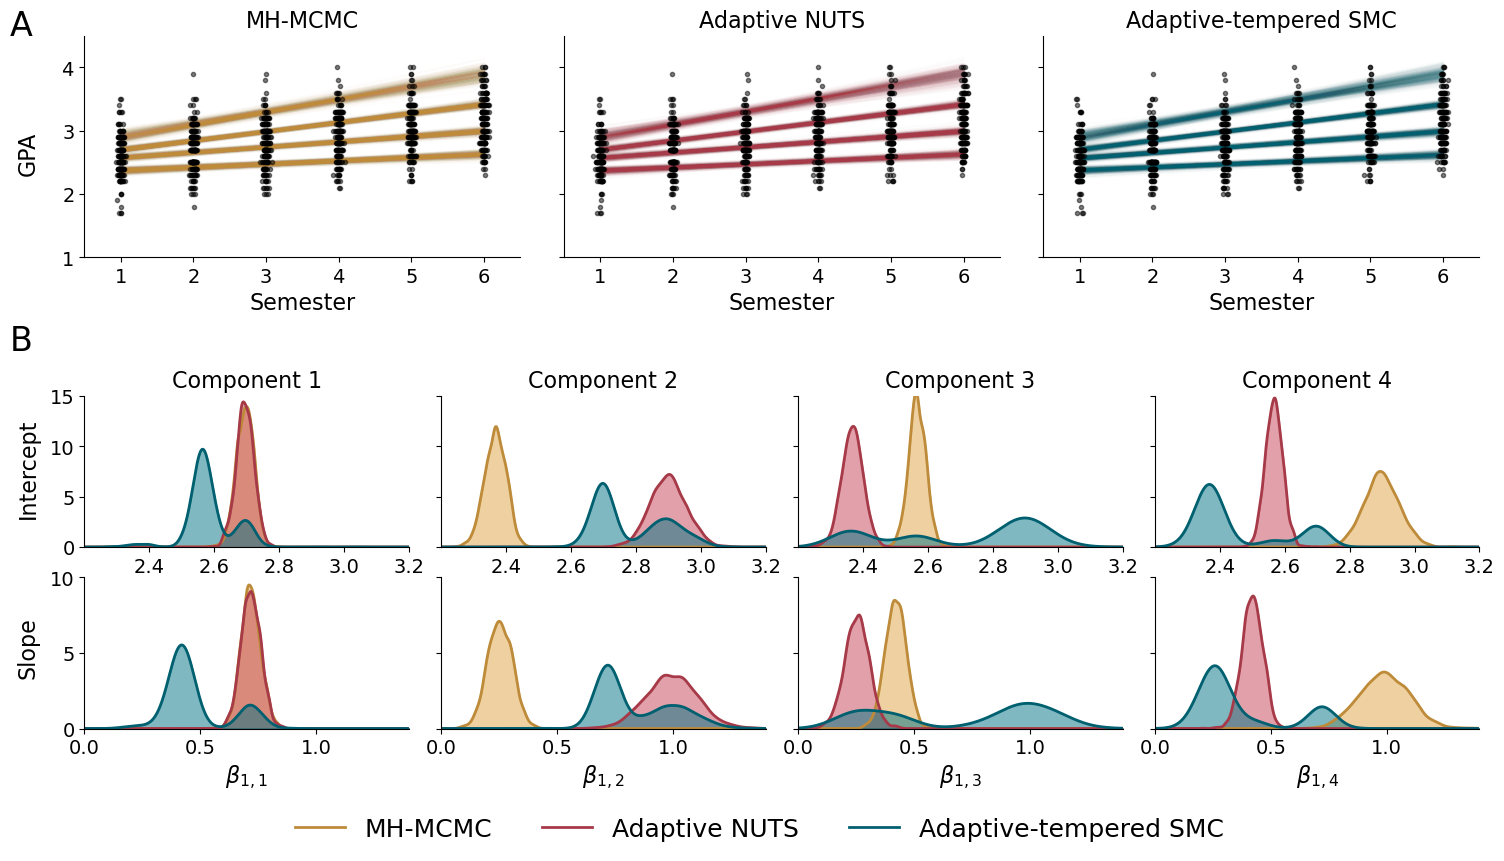

In [31]:
import matplotlib.gridspec as gridspec

methodlabels = ['MH-MCMC', 'Adaptive NUTS', 'Adaptive-tempered SMC']
output = [mh_samples.position, nuts_samples.position, particles.particles]

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
LARGE_SIZE = 24

M = len(methodlabels)
colors = ['#edae49', '#d1495b', '#00798c'] 

fig = plt.figure(figsize=(18, 9))
gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1.5], hspace=0.5, wspace=0.0)

gs_inference = gs[0].subgridspec(1, M)
gs_coef = gs[1].subgridspec(2, K)

axes_inference = gs_inference.subplots(sharex=True, sharey=True)
axes_coef = gs_coef.subplots(sharex='row', sharey='row')

for samples, method, ax, color in zip(output, methodlabels, axes_inference, colors):
    key, subkey = jrnd.split(key)
    plot_fit(subkey, Y, samples, K, degree, color=darken_hex_color(color, 20), ax=ax, title=method)  # fairly slow so plot with care
axes_inference[0].set_ylabel('GPA', fontsize=MEDIUM_SIZE)

plt.subplots_adjust(wspace=0.1, hspace=0.2)

param_ranges = {0:jnp.linspace(2.2, 3.2, num=1000), 
                1: jnp.linspace(0.0, 1.4, num=1000)}

ylims = [15, 10]

for d in [0, 1]:
    param_range = param_ranges[d]      

    for k in range(K):
        ax = axes_coef[d, k]    
        for m in range(M):  
            samples = output[m]
            pdf = gaussian_kde(samples['eta'][:, k, d].flatten())
            y = pdf(param_range)
            ax.plot(param_range, y, color=darken_hex_color(colors[m], 20), lw=2, label=methodlabels[m])
            ax.fill_between(param_range, y, jnp.zeros_like(y), color=darken_hex_color(colors[m], 5), alpha=0.5)
            ax.set_xlabel(r'$\beta_{{{:s}}}$'.format(f'{d},{k+1}'), fontsize=MEDIUM_SIZE)
            ax.tick_params(axis='both', labelsize=SMALL_SIZE)
            ax.set_xlim([param_range[0], param_range[-1]])
            ax.set_ylim(bottom=0, top=ylims[d])
            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)        
        
axes_coef[0, 0].set_ylabel('Intercept', fontsize=MEDIUM_SIZE)
axes_coef[1, 0].set_ylabel('Slope', fontsize=MEDIUM_SIZE)

ylabel_xloc = 0.1
axes_inference[0].yaxis.set_label_coords(ylabel_xloc, 0.75, transform=plt.gcf().transFigure)
axes_coef[0, 0].yaxis.set_label_coords(ylabel_xloc, 0.4, transform=plt.gcf().transFigure)
axes_coef[1, 0].yaxis.set_label_coords(ylabel_xloc, 0.2, transform=plt.gcf().transFigure)

for k in range(K):
    axes_coef[0, k].set_title(f'Component {k+1}', fontsize=MEDIUM_SIZE, bbox=dict(facecolor='white', alpha=0.0))

handles, labels = axes_coef[1, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=M, frameon=False, 
           bbox_to_anchor=(0, -0.04, 1, 1), bbox_transform=plt.gcf().transFigure, fontsize=BIGGER_SIZE);

plt.figtext(0.09, 0.88, 'A', size=LARGE_SIZE, ha='center', transform=plt.gcf().transFigure)
plt.figtext(0.09, 0.53, 'B', size=LARGE_SIZE, ha='center', transform=plt.gcf().transFigure);